In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
rows = 10
cols = 10

# Q1 Creating reward function1 heatmap

In [3]:
reward_function_1 = [[0.0 for x in range(cols)] for y in range(rows)]
reward_function_1[rows - 1][cols - 1] = 1.0
reward_function_1 = np.array(reward_function_1)


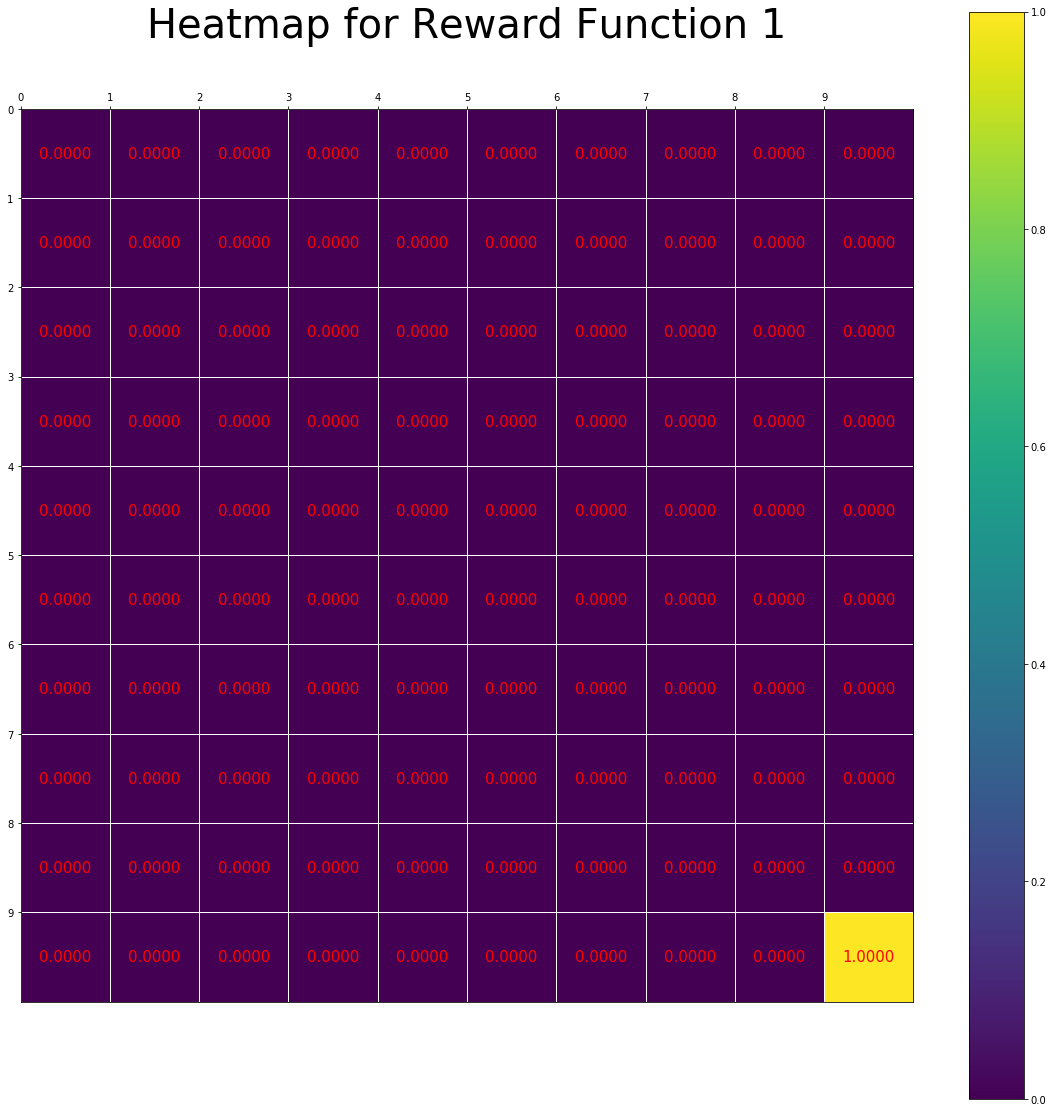

In [4]:
plt.figure(figsize = (20,20))

plt.imshow(reward_function_1)
ax = plt.gca()
plt.colorbar()
#plt.title('Reward Function 1 heatmap', y=1.1)
for y in range(10):
    for x in range(10):
        plt.text(x, y , '%.4f' % int(reward_function_1[y, x]),
                 horizontalalignment='center',
                 verticalalignment='center', fontsize=15, color = 'r'
                 )
ax.xaxis.tick_top()
ax.set_xticks(np.arange(-0.5, 9, 1))
ax.set_yticks(np.arange(-0.5, 9, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.grid(color='w', linestyle='-', linewidth=1)
plt.text(0.5, 1.08, 'Heatmap for Reward Function 1',
         horizontalalignment='center',
         fontsize=40,
         transform = ax.transAxes)
ax.xaxis.set_label_position('top')


# 2 Creating the environment for the agent

In [5]:
#Utility functions for the environment setup

def get_neighbors(state, rows, cols):
    left = state - rows
    
    right = state + rows
    
    #for states in last col
    if(right > rows*cols - 1):
        right = -1
    
    #for states in first row
    if(state % rows == 0):
        up = -1
    else:
        up = state - 1
    
    #for states in last row
    if(state % rows == rows -1):
        down = -1
    else:
        down = state + 1
    
    return {'L':left,'R':right,'U':up,'D': down}

def assign_prob(current_state, neighbors, action, wind_prob):

    current_state_prob = 0.0
    result_prob = {}
    for action_neigh in neighbors.keys():
        goto_state = neighbors[action_neigh]
        if(action_neigh == action):
            
            if(goto_state < 0):
                current_state_prob = current_state_prob + 1 - wind_prob + (wind_prob/4)
                result_prob[action_neigh] = 0.0
            else:
                result_prob[action_neigh] = 1 - wind_prob + (wind_prob/4)
        
        else:
            
            if(goto_state < 0):
                current_state_prob = current_state_prob + (wind_prob/4)
                result_prob[action_neigh] = 0.0
            else:
                result_prob[action_neigh] = wind_prob / 4
                
    result_prob['C'] = current_state_prob
    return result_prob
                

In [11]:
#Value iteration algorithm
def value_iteration_algo(num_states, action_set, transition_probabilities, 
                         reward_function, estimation_epsilon, discount_factor):

    #initialization
    value_state = [0.0 for state in range(num_states)]
    value_state_new = value_state


    delta = math.inf
    #Estimation
    while(delta > estimation_epsilon):
        delta = 0
        for curr_state in range(num_states):

            value = value_state[curr_state]
            temp_value = -math.inf
            for action in action_set:
                transition_vector = transition_probabilities[action][curr_state]
                reward_vector = reward_function
                temp_value = max(temp_value, 
                                 value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state))

            value_state_new[curr_state] = temp_value
            delta = max(delta, abs(value - value_state_new[curr_state]))
            
        value_state = value_state_new

    pi_state = [0.0 for state in range(num_states)]

    #Computation
    for curr_state in range(num_states):
            temp_action = 'C'
            temp_value = -math.inf
            for action in action_set:
                transition_vector = transition_probabilities[action][curr_state]
                reward_vector = reward_function
                if value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state) > temp_value:
                    temp_action = action
                    temp_value = value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state)

            pi_state[curr_state] = temp_action

    #Return the optimal value policies and the actions
    return [value_state, pi_state]

    
#value iteration algo helper         
def value_iteration_comp(num_states, transition_vector, reward_vector, discount_factor, value_state):
    new_value_state = 0
    
    for i in range(num_states):
        new_value_state = new_value_state + (transition_vector[i] * (reward_vector[i] + (discount_factor * value_state[i])))
        
    return new_value_state

In [12]:
#Environment setup starts here:
grid_space = [[0.0 for x in range(cols)] for y in range(rows)]
for j in range(rows):
    for i in range(cols):
        grid_space[j][i] = i * 1.0 * rows + j

In [13]:
# Just a fun way to visualize the 100 states in a 10 X 10 grid
grid_space = np.array(grid_space)
#Total number of possible states
num_states = rows * cols  #100 for this case

#Total possible actions (up, left, Right, Down)
action_set = ['U','L','R','D']

#Number of actions
action_num = len(action_set)

#Wind probability w
wind_prob = 0.1

#Discount factor (gamma in the range [0,1) )
discount_factor = 0.8

#Setting up the transition matrix. We have a dictionary for the key being each action in our action set and the value
#being a 100 X 100 matrix denoting the probability of moving from any node i to j given that action
transition_probabilities = {}

for action in action_set:
    
    transition_matrix = [[0.0 for i in range(num_states)] for j in range(num_states)]
    
    for i in range(num_states):
        neighbors_i = get_neighbors(i, rows, cols)
        probs = assign_prob(current_state = i, neighbors = neighbors_i, action = action, wind_prob = wind_prob)
        for key in probs.keys():
            if(key == 'C'):
                transition_matrix[i][i] = probs[key]
            else:
                new_state = neighbors_i[key]
                if(new_state >= 0):
                    transition_matrix[i][new_state] = probs[key]
    
    transition_probabilities[action] = transition_matrix
        

In [14]:
#Reward function (in this case a vector as it depends only on end state) for this computation
reward_function = reward_function_1.flatten('F')
estimation_epsilon = 0.01
[value_state,pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function, estimation_epsilon, discount_factor)

# Q3

In [15]:
optimal_value_state = np.asarray(value_state)
optimal_value_state = np.reshape(optimal_value_state, (rows,cols), order = 'F')

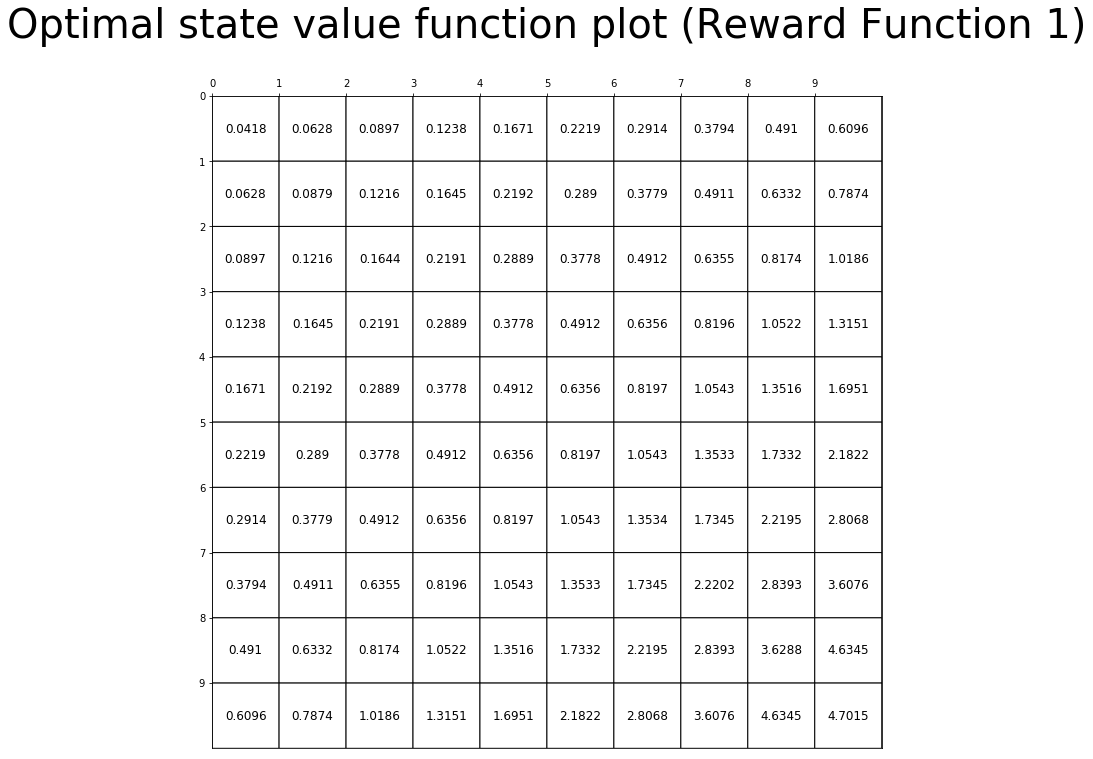

In [16]:
#Plotting the optiaml value function
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (12,12))

plt.pcolor(optimal_value_state, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, np.around(optimal_value_state[i][j], decimals = 4),
                  ha = 'center',va = 'center', size = 12, color="k")
plt.title('Optimal state value function plot (Reward Function 1)', y = 1.08, size = 40)
ax.xaxis.tick_top()
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.invert_yaxis()
ax.xaxis.set_label_position('top')

          0         1         2         3         4         5         6  \
0  0.041796  0.062838  0.089742  0.123849  0.167081  0.221883  0.291354   
1  0.062838  0.087870  0.121557  0.164514  0.219246  0.288990  0.377871   
2  0.089742  0.121557  0.164390  0.219132  0.288903  0.377826  0.491156   
3  0.123849  0.164514  0.219132  0.288900  0.377825  0.491159  0.635601   
4  0.167081  0.219246  0.288903  0.377825  0.491159  0.635603  0.819695   
5  0.221883  0.288990  0.377826  0.491159  0.635603  0.819696  1.054322   
6  0.291354  0.377871  0.491156  0.635601  0.819695  1.054322  1.353351   
7  0.379420  0.491061  0.635490  0.819610  1.054265  1.353324  1.734461   
8  0.490983  0.633219  0.817355  1.052191  1.351572  1.733180  2.219527   
9  0.609648  0.787354  1.018597  1.315059  1.695073  2.182231  2.806802   

          7         8         9  
0  0.379420  0.490983  0.609648  
1  0.491061  0.633219  0.787354  
2  0.635490  0.817355  1.018597  
3  0.819610  1.052191  1.315059  
4  1

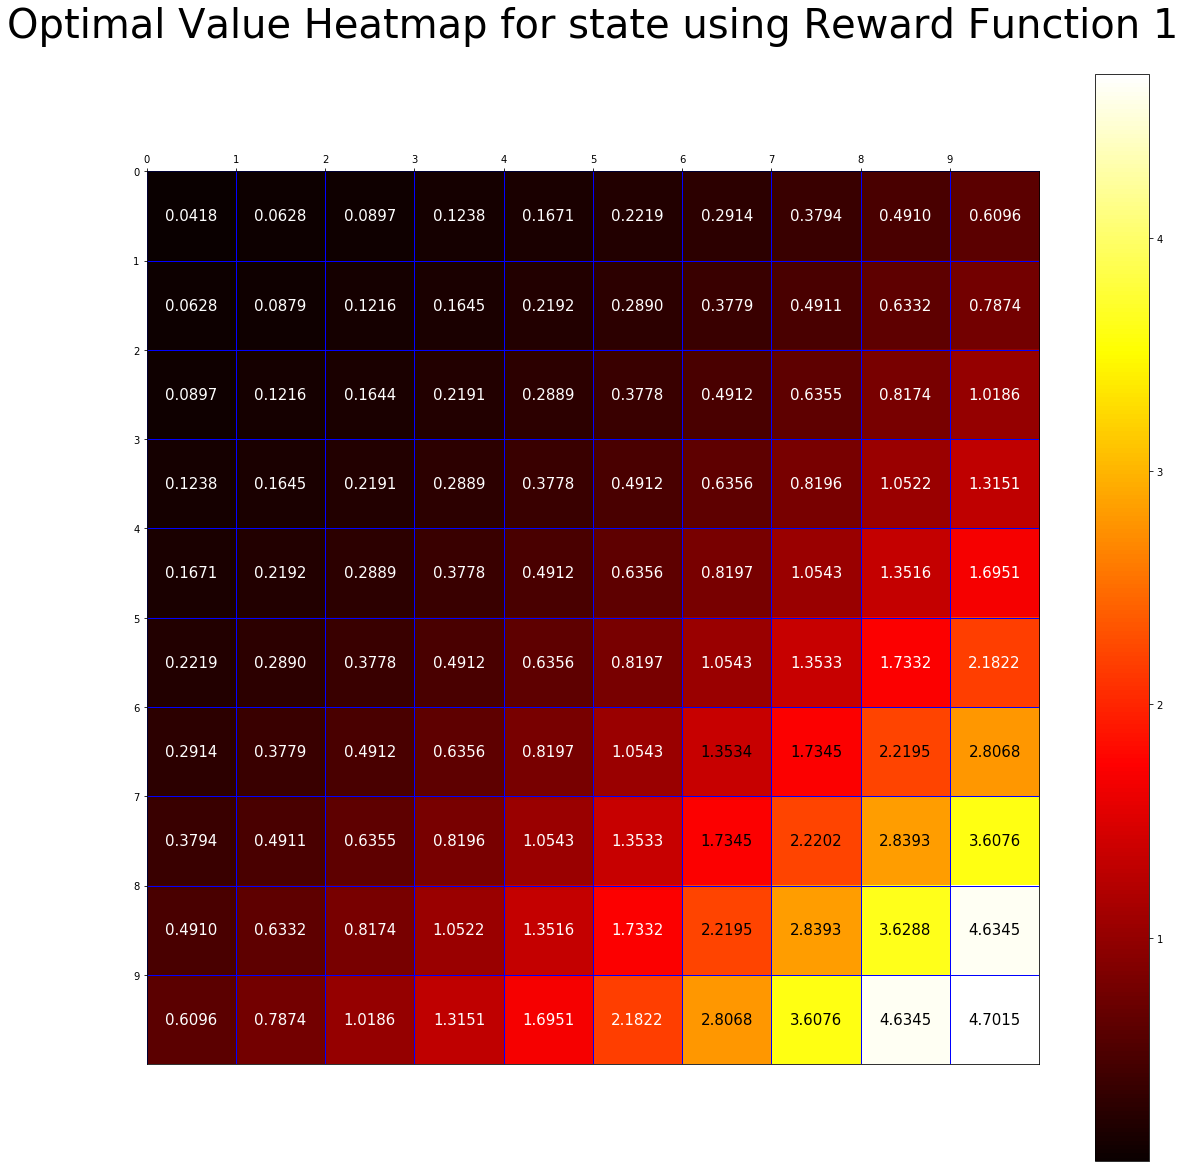

In [17]:
df = pd.DataFrame(optimal_value_state, columns = [i for i in range (cols)], index = [j for j in range(rows)])
print(df)
#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP

plt.figure(figsize = (20,20))

plt.imshow(optimal_value_state, cmap = 'hot')
ax = plt.gca()
plt.colorbar()
#plt.title('Reward Function 1 heatmap', y=1.1)
for y in range(10):
    for x in range(10):
        color = 'w'
        if x >5 and y>5:
            color = 'k'
        plt.text(x, y , '%.4f' % (optimal_value_state[y, x]),
                 horizontalalignment='center',
                 verticalalignment='center', fontsize=15, color = color
                 )
ax.xaxis.tick_top()
ax.set_xticks(np.arange(-0.5, 9, 1))
ax.set_yticks(np.arange(-0.5, 9, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.grid(color='b', linestyle='-', linewidth=1)

plt.text(0.5, 1.15, 'Optimal Value Heatmap for state using Reward Function 1',
         horizontalalignment='center',
         fontsize=40,
         transform = ax.transAxes)
ax.xaxis.set_label_position('top')



# Q5

In [18]:
optimal_value_action = np.asarray(pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP
#Plotting the optiaml value function


,0,1,2,3,4,5,6,7,8,9
0,→,→,→,→,→,→,→,↓,↓,↓
1,↓,→,→,→,→,→,↓,↓,↓,↓
2,↓,↓,→,→,→,↓,↓,↓,↓,↓
3,↓,↓,↓,↓,↓,↓,↓,↓,↓,↓
4,↓,↓,↓,→,↓,↓,↓,↓,↓,↓
5,↓,↓,→,→,→,↓,↓,↓,↓,↓
6,↓,→,→,→,→,→,↓,↓,↓,↓
7,→,→,→,→,→,→,→,→,↓,↓
8,→,→,→,→,→,→,→,→,→,↓
9,→,→,→,→,→,→,→,→,→,→


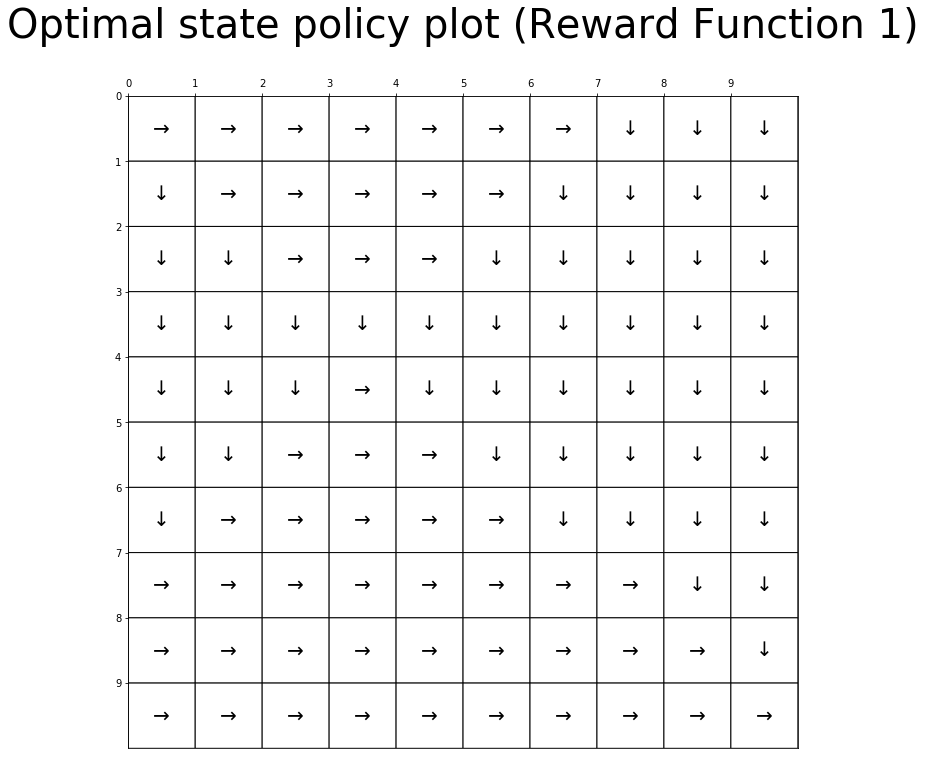

In [19]:
cmap = plt.cm.get_cmap(name = 'gray', lut = 1)
plt.figure(figsize = (12,12))
plt.pcolor(reward_function_1, cmap = cmap, edgecolor = 'k', linewidth = 1)
ax = plt.gca()

for i in range(10):
    for j in range(10):
        text = ax.text(j+0.5, i + 0.5, optimal_value_action[i][j],
                  ha = 'center',va = 'center', size = 20, color="k")
plt.title('Optimal state policy plot (Reward Function 1)', y = 1.08, size = 40)
ax.xaxis.tick_top()
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.invert_yaxis()
ax.xaxis.set_label_position('top')